In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import plot_tree
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.base import TransformerMixin
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from util import process_dataframe
plt.rcParams['figure.figsize'] = [10, 5]
mpl.rcParams['figure.dpi']= 100

In [2]:
train_df = pd.read_csv('fliiga2018-2022.csv', header=0,sep='|', on_bad_lines='skip')
# Ignore shots outside of the rink coordinates 
train_df = process_dataframe(train_df)


C:\Users\Tomas\anaconda3\envs\sbdata\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\Tomas\condapy\util.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Angle_Deg'] = df.apply(lambda x: calculate_angle(x['ShotX'], x['ShotY']), axis=1)
C:\Users\Tomas\condapy\util.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [3]:
train_df.head()

,Unnamed: 0,UniqueID,ShotX,ShotY,GoalX,GoalY,Period,GameTime,LogTime,EventType,...,BlockingPlayerID,Plus,Minus,Ass1Jersey,Ass2Jersey,Goaltype,GAME_ID,Angle_Deg,Distance,TimeFromPreviousShot
2,2,22241,201.0,139.0,0.0,0.0,1,270,2017-09-17 16:06:07,0,...,23327922,NaN,NaN,NaN,NaN,NaN,1477,13.966639,160.552172,214
4,4,22243,256.0,351.0,0.0,0.0,1,342,2017-09-17 16:07:51,0,...,28848891,NaN,NaN,NaN,NaN,NaN,1477,14.483390,191.760267,19
5,5,22244,136.0,324.0,0.0,0.0,1,374,2017-09-17 16:09:03,0,...,23327922,NaN,NaN,NaN,NaN,NaN,1477,22.917681,82.927679,32
6,6,22245,194.0,166.0,0.0,0.0,1,440,2017-09-17 16:10:50,0,...,23327922,NaN,NaN,NaN,NaN,NaN,1477,17.973198,136.883162,66
8,8,22247,307.0,59.0,0.0,0.0,1,518,2017-09-17 16:13:15,0,...,28848891,NaN,NaN,NaN,NaN,NaN,1477,8.162575,292.412380,64


In [4]:
# Split the data in to features and the results
y = train_df["EventType"].copy()
X = train_df.drop(["Unnamed: 0", "UniqueID", "GameTime", "GoalX", "GoalY", "Period", "LogTime", "LTeamID", "RTeamID",
                   "ShootingTeamID", "ShootingPlayerID", "SPJersey", "BlockingPlayerID", "Plus", "Minus", "Ass1Jersey",
                   "Ass2Jersey", "Goaltype", "GAME_ID", "EventType"], axis=1).copy()


In [5]:
X.head()

,ShotX,ShotY,Angle_Deg,Distance,TimeFromPreviousShot
2,201.0,139.0,13.966639,160.552172,214
4,256.0,351.0,14.483390,191.760267,19
5,136.0,324.0,22.917681,82.927679,32
6,194.0,166.0,17.973198,136.883162,66
8,307.0,59.0,8.162575,292.412380,64


In [6]:
# Split the data in to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8, stratify=y)

In [7]:
# Let's verify that training and test datasets have equal amount of goals
print(sum(y)/len(y),sum(y_train)/len(y_train), sum(y_test)/len(y_test))

0.13432026882636233 0.1343179574533981 0.13432951378135646


In [8]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "subsample"        : [0.2, 0.4, 0.6, 0.7 , 1]
}


In [9]:
classifier=xgb.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=10,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [10]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Tomas\anaconda3\envs\sbdata\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:50:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [11]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, gamma=0.4, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.2, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [12]:
random_search.best_params_

{'subsample': 0.2,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.15,
 'gamma': 0.4,
 'colsample_bytree': 0.4}

In [13]:
classifier = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, gamma=0.4, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.2, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [14]:
classifier.fit(X_train,y_train)
y_pred = classifier.predict_proba(X_test)
X_test["xG"] = y_pred[:,1]
X_sum_goals = X_test["xG"].sum()
print(X_sum_goals, y_test.sum())

[22:51:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1742.8049 1735


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

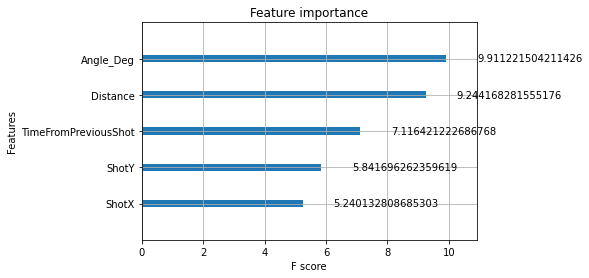

In [15]:
# Let's look at the importance of features
xgb.plot_importance(classifier, ax=plt.gca(),importance_type='gain')

In [16]:
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred[:,1]),log_loss(y_test, y_pred))

0.6766432969475029 0.3684981027556039


In [21]:
X_test["xG"] = y_pred[:,1]

In [22]:
X_sum_goals = X_test["xG"].sum()

In [23]:
print(X_sum_goals, y_test.sum())

1732.618 1735


In [24]:
low_xg_shots = X_test.loc[X_test['xG'] < 0.15]
med_xg_shots = X_test.loc[(X_test['xG'] >= 0.15) & (X_test['xG'] <= 0.6)]
high_xg_shots = X_test.loc[X_test['xG'] > 0.6]

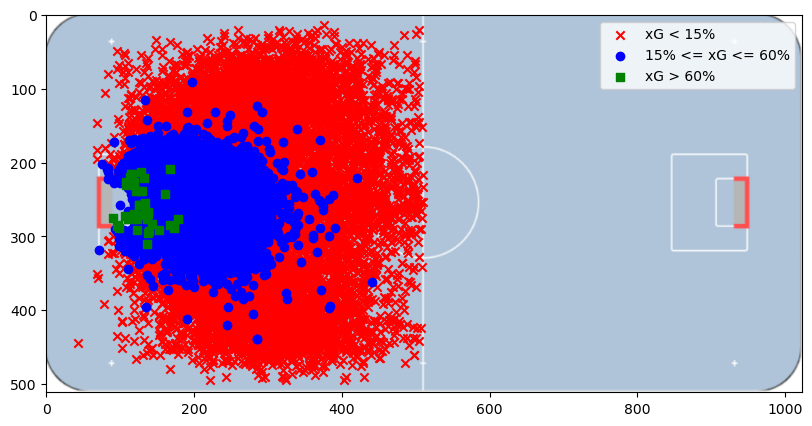

In [25]:
plt.rcParams['figure.figsize'] = [10, 5]
mpl.rcParams['figure.dpi']= 100
plt.scatter(low_xg_shots["ShotX"], low_xg_shots["ShotY"], c='r', marker='x', label='xG < 15%')
plt.scatter(med_xg_shots["ShotX"], med_xg_shots["ShotY"], c='b', marker='o', label='15% <= xG <= 60%')
plt.scatter(high_xg_shots["ShotX"], high_xg_shots["ShotY"], c="g", marker="s", label="xG > 60%")

plt.legend(loc='upper right')
img = plt.imread("lkartta2.png")
plt.imshow(img)


plt.xlim([0, 1023])
plt.ylim([0, 511])
plt.gca().invert_yaxis()

Text(0, 0.5, 'The amount of shots')

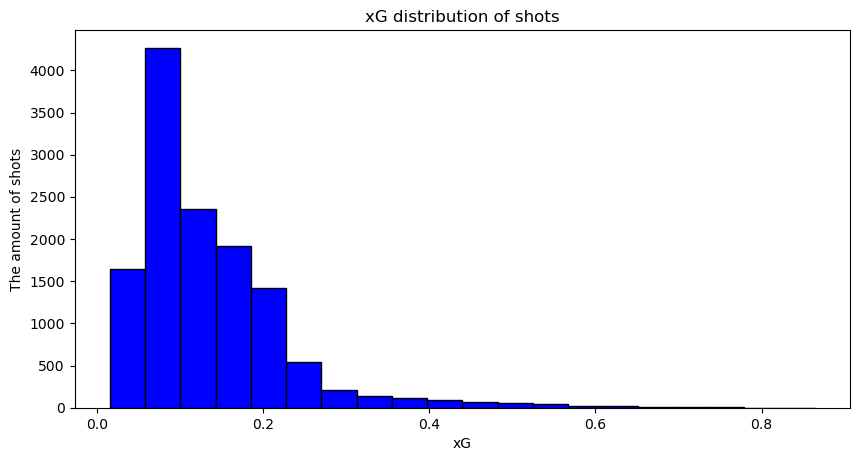

In [26]:
plt.hist(X_test['xG'], color = 'blue', edgecolor = 'black',
         bins = int(100/5))

plt.title('xG distribution of shots')
plt.xlabel('xG')
plt.ylabel('The amount of shots')

Text(0, 0.5, 'The amount of shots')

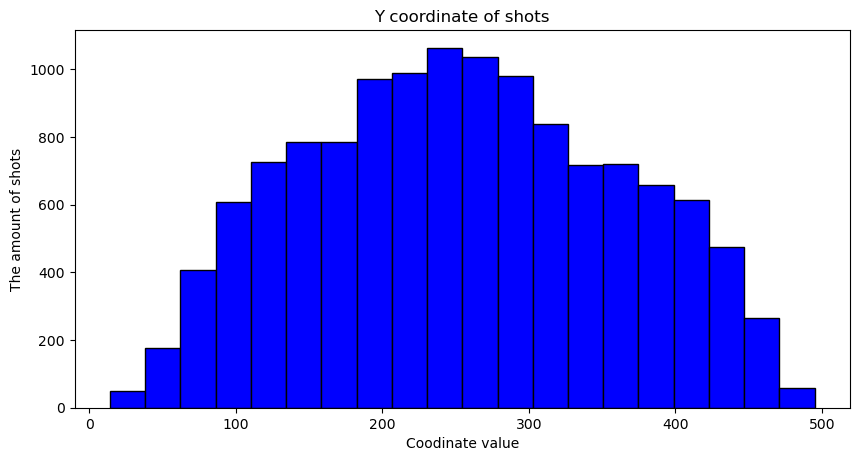

In [27]:
plt.hist(X_test['ShotY'], color = 'blue', edgecolor = 'black',
         bins = int(100/5))

plt.title('Y coordinate of shots')
plt.xlabel('Coodinate value')
plt.ylabel('The amount of shots')

Text(0, 0.5, 'The amount of shots')

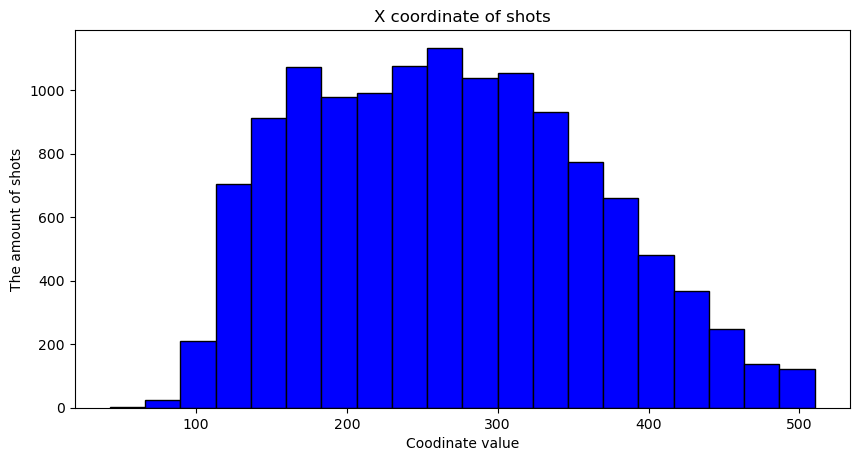

In [28]:
plt.hist(X_test['ShotX'], color = 'blue', edgecolor = 'black',
         bins = int(100/5))

plt.title('X coordinate of shots')
plt.xlabel('Coodinate value')
plt.ylabel('The amount of shots')

Text(0, 0.5, 'The amount of shots')

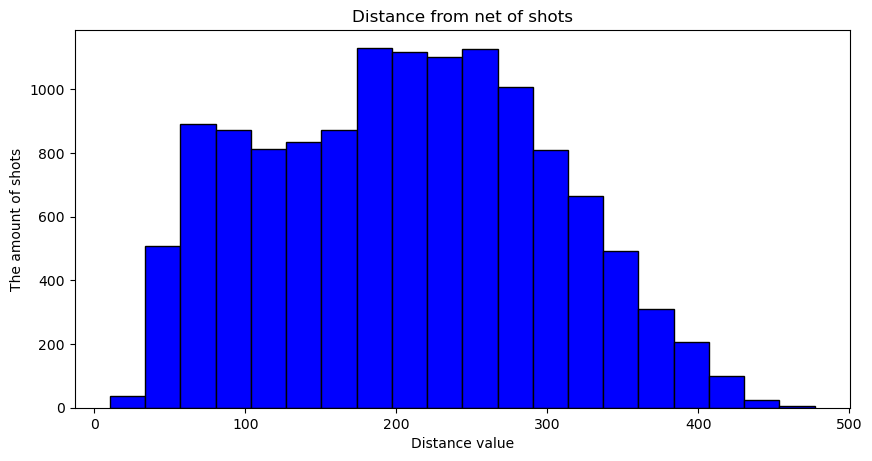

In [29]:
plt.hist(X_test['Distance'], color = 'blue', edgecolor = 'black',
         bins = int(100/5))

plt.title('Distance from net of shots')
plt.xlabel('Distance value')
plt.ylabel('The amount of shots')

Text(0, 0.5, 'The amount of shots')

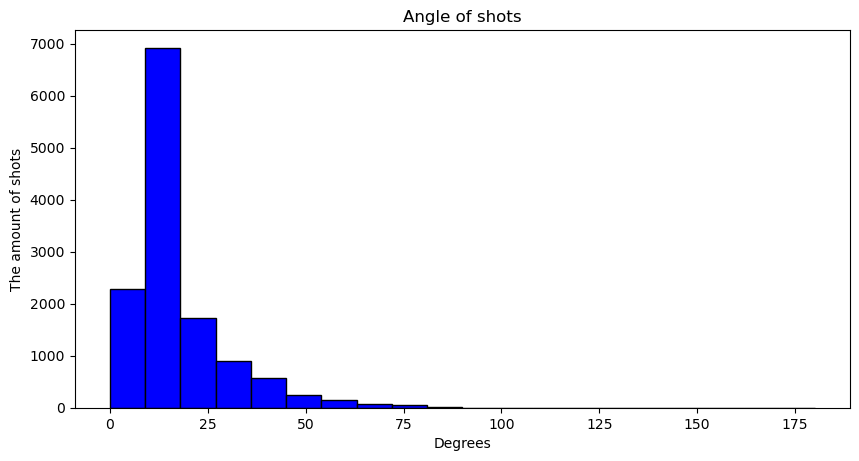

In [30]:
plt.hist(X_test['Angle_Deg'], color = 'blue', edgecolor = 'black',
         bins = int(100/5))

plt.title('Angle of shots')
plt.xlabel('Degrees')
plt.ylabel('The amount of shots')

## Results and Conclusion 

* Due to a lack of features for xgboost model, most of the shots group up around 10% xG
* Floorball is a high-scoring game. Therefore, shots from far-out can create significant xG


In [31]:
classifier.save_model("model_xgboost_4.json")

In [32]:
X_train.dtypes

ShotX                          float64
ShotY                          float64
Angle_Deg                      float64
Distance                       float64
TimeFromPreviousShot             int64
DistanceFromPreviousShot       float64
AngleChangeFromPreviousShot    float64
dtype: object

In [29]:
#classifier.save_model("model_xgboost_opt.json")